# Digit Recognition from Audio Recordings
This notebook deals with the classification or recognition of spoken digits using Convolutional Neural Networks (CNN for
short). The dataset used is freely available and can be downloaded from the platform Kaggle platform. It contains a
total of 3,000 audio recordings of different speakers who have spoken each digit 50 times. The code processes the audio
recordings, extracts features, and trains a CNN.

Dataset available at: https://www.kaggle.com/jackvial/freespokendigitsdataset

The _train.csv_ file, and the _recordings_ directory should be in the same directory as this notebook.

## Import of the required packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
from librosa import display
import os
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

## Data Exploration
In the first step, the so-called Data Exploration, individual audio recordings are visualized and examined for first
visible differences. From the available 3,000 recordings, a random recording is chosen for different digits and
visualized as waveform and mel spectrogram.

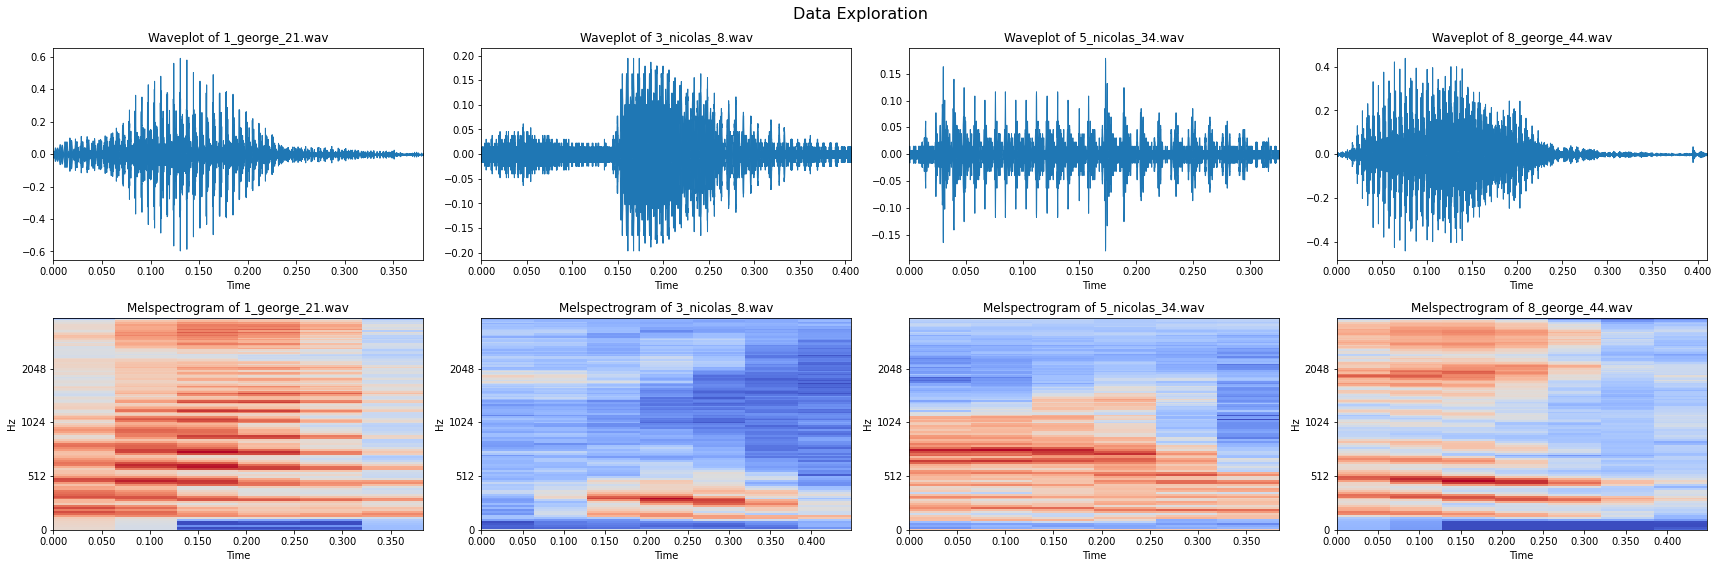

In [2]:
visualize_digits = [1, 3, 5, 8]

description = pd.read_csv('../input/freespokendigitsdataset/train.csv')
fig, axs = plt.subplots(nrows=2, ncols=(len(visualize_digits)))
axs = axs.flatten()
fig.suptitle('Data Exploration', fontsize=16)
fig.set_size_inches(24, 8)
for i, digit in enumerate(visualize_digits):
    # Select random file for selected digit
    rand_file = np.random.choice(description[description['label'] == digit]['file_name'])
    # Load audio and plot waveform and melspectrogram
    audio, sr = librosa.load(os.path.join('../input/freespokendigitsdataset/recordings', rand_file), sr=None)
    librosa.display.waveplot(y=audio, sr=sr, x_axis='time', ax=axs[i])
    axs[i].set(title=f'Waveplot of {rand_file}')
    mels_db = librosa.power_to_db(S=librosa.feature.melspectrogram(y=audio, sr=sr), ref=1.0)
    librosa.display.specshow(data=mels_db, sr=sr, x_axis='time', y_axis='mel', ax=axs[i+len(visualize_digits)])
    axs[i+len(visualize_digits)].set(title=f'Melspectrogram of {rand_file}')
plt.tight_layout()
plt.show()

## Feature Engineering
The next step is to extract features from the audio recordings, in this case a Melspectrogram. In order later train the
neural network, all features must have the same shape. However, since the recordings are of different lengths, they are
brought to a length of 1s by time-stretching. The features and labels of the recordings are stored in numpy arrays to be
able to work with them easily later.

In [3]:
feature_list = []
label_list = []
# Iterate over all files in given source path
print('Preparing feature dataset and labels.')
for file in tqdm(os.listdir('../input/freespokendigitsdataset/recordings')):
    # Skip if it's not a wav file
    if not file.endswith('.wav'):
        continue
    # Load audio and stretch it to length 1s
    audio_path = os.path.join('../input/freespokendigitsdataset/recordings', file)
    audio, sr = librosa.load(path=audio_path, sr=None)
    audio = librosa.effects.time_stretch(y=audio, rate=len(audio)/sr)
    # Calculate features and get the label from the filename
    mels = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=2048, hop_length=512)
    mels_db = librosa.power_to_db(S=mels, ref=1.0)
    feature_list.append(mels_db.reshape((128, 16, 1)))
    label_list.append(file[0])
features = np.array(feature_list)
labels = np.array(label_list)

Preparing feature dataset and labels.


100%|██████████| 3000/3000 [00:59<00:00, 50.02it/s]


## Model Architecture
After the data is prepared, the next step is to define the architecture or the structure of the neural network.
Using the Keras Sequential API, the individual layers can be defined one after the other.
1. Input layer: In the first layer it is only defined which form the incoming data has. This does not necessarily be
entered as a separate layer, but can also be defined in the subsequent layer.
2. Conv2D Layers & MaxPooling: The next part is the core of CNNs. Within the Convolutional Layers possible relevant
correlations are determined from the data by kernels. The first number indicates in each case, how many filters are to
be generated. The MaxPooling layer reduces the output of the previous layers by again running a kernel over the data
and selecting the largest value from a 2×2 field.
3. Flatten & Dropout: The Flatten layer generates a 1-dimensional tensor/vector from an n-dimensional input. The
Dropout layer randomly deactivates the given fraction of neurons per epoch. By this methodology the so-called
overfitting (overfitting to the training data) can be reduced.
4 Dense Layers: Finally, the CNN contains a Dense Layer with 64 neurons as well as the actual classifier
(layer with 10 neurons, one for each class). Through the Softmax activation function, values between 0 and 1 are
emitted which can be seen as the probability for each class.

The network is then compiled with an optimizer, loss function as well as metrics.

In [4]:
model = keras.Sequential(layers=[
        keras.layers.InputLayer(input_shape=features[0].shape),
        keras.layers.Conv2D(16, 3, padding='same', activation=keras.activations.relu),
        keras.layers.MaxPooling2D(),
        keras.layers.Conv2D(32, 3, padding='same', activation=keras.activations.relu),
        keras.layers.MaxPooling2D(),
        keras.layers.Flatten(),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(64, activation=keras.activations.relu),
        keras.layers.Dense(10, activation=keras.activations.softmax)
    ])
model.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 16, 16)       160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 8, 16)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 8, 32)         4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 4, 32)         0         
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
dropout (Dropout)            (None, 4096)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                2


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_P

## Train the model
Before the model can be trained, the labels have to be encoded, and the data has to be partitioned.
1. Label encoding: As defined in the last step, the last layer of the network contains 10 neurons, so the output is a
vector of length 10. The labels are currently in pure text format, which the net cannot process. With the help of the
so-called One-Hot-Encoding, the labels can be converted into vectors of length 10 with a 1 at one position (hence
One-Hot).
2. Splitting the data: Basically, in machine learning, the data set is divided into at least two parts.
The largest part is the training data, which is used to train the model. The second part is the test data, which can be
used to evaluate the model after training. In this example, when training the model, it is determined that a part of the
training data should be retained. With this data it is already possible during the training to determine the score the
model can achieve on unseen data.

After training, the results of the history can be visualized over the individual epochs.

2022-01-06 14:57:18.787736: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
23/23 [==============================] - 1s 34ms/step - loss: 4.8334 - accuracy: 0.1259 - val_loss: 2.2540 - val_accuracy: 0.1921
Epoch 2/50
23/23 [==============================] - 1s 24ms/step - loss: 2.1457 - accuracy: 0.2537 - val_loss: 1.9679 - val_accuracy: 0.3508
Epoch 3/50
23/23 [==============================] - 1s 24ms/step - loss: 1.6532 - accuracy: 0.4667 - val_loss: 1.3218 - val_accuracy: 0.6095
Epoch 4/50
23/23 [==============================] - 1s 24ms/step - loss: 1.0066 - accuracy: 0.6599 - val_loss: 0.7849 - val_accuracy: 0.7524
Epoch 5/50
23/23 [==============================] - 1s 24ms/step - loss: 0.6713 - accuracy: 0.7973 - val_loss: 0.4873 - val_accuracy: 0.8635
Epoch 6/50
23/23 [==============================] - 1s 24ms/step - loss: 0.3854 - accuracy: 0.8810 - val_loss: 0.3683 - val_accuracy: 0.8937
Epoch 7/50
23/23 [==============================] - 1s 23ms/step - loss: 0.3112 - accuracy: 0.9068 - val_loss: 0.2640 - val_accuracy: 0.9222
Epoch 8/50
23

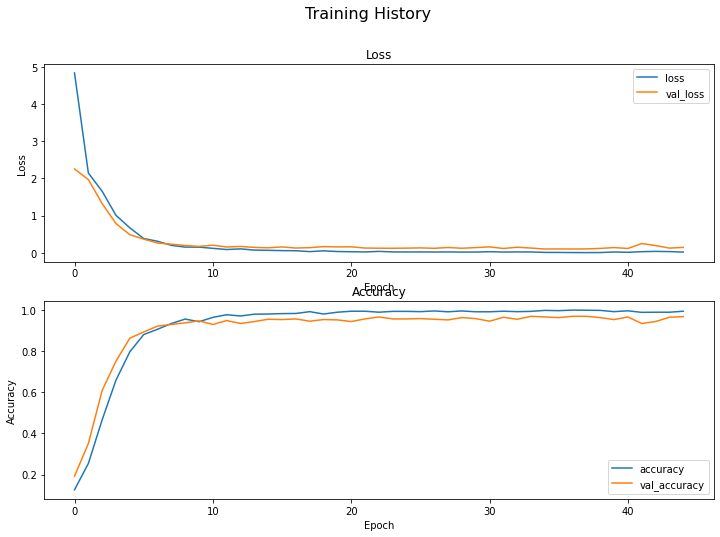

In [5]:
# Set parameters for data splitting and training
TEST_SIZE = 0.3
BATCH_SIZE = 64
EPOCHS = 50

# Encode Labels
encoded_labels = tf.one_hot(indices=labels, depth=10)
# Split dataset to train and test data
X_train, X_test, y_train, y_test = train_test_split(features, encoded_labels.numpy(), test_size=TEST_SIZE)

# Train the model
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(x=X_train, y=y_train, validation_split=TEST_SIZE, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[early_stopping])

# Plot the training history
fig, axs = plt.subplots(2)
fig.set_size_inches(12, 8)
fig.suptitle('Training History', fontsize=16)
axs[0].plot(history.epoch, history.history['loss'], history.history['val_loss'])
axs[0].set(title='Loss', xlabel='Epoch', ylabel='Loss')
axs[0].legend(['loss', 'val_loss'])
axs[1].plot(history.epoch, history.history['accuracy'], history.history['val_accuracy'])
axs[1].set(title='Accuracy', xlabel='Epoch', ylabel='Accuracy')
axs[1].legend(['accuracy', 'val_accuracy'])
plt.show()

## Evaluate the model
After training, the accuracy on new data can be determined using the test set that the model has not seen before.
This indicates whether overfitting or underfitting is present, or the training has achieved a good result.

The results of the prediction can be displayed in a confusion matrix. This shows which class a recording really has and
which class the model predicted. In the main diagonal the correct predictions can be found.

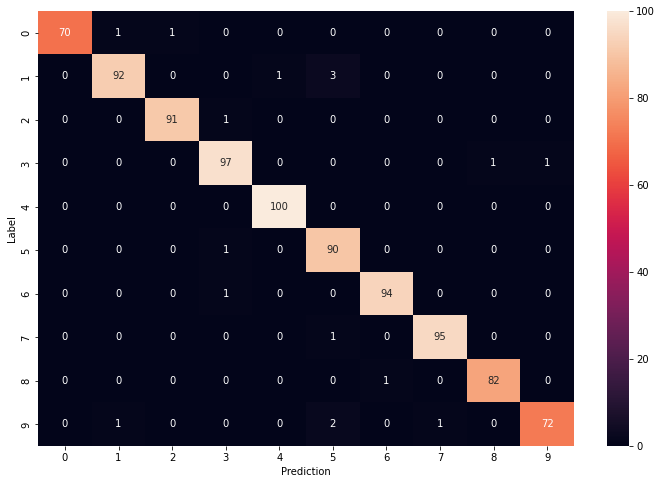

In [6]:
y_predicted = np.argmax(model.predict(x=X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
label_names = np.unique(labels)
confusion_matrix = tf.math.confusion_matrix(labels=y_true, predictions=y_predicted)
fig = plt.figure()
fig.set_size_inches(12, 8)
sns.heatmap(confusion_matrix, xticklabels=label_names, yticklabels=label_names, annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()